In [1]:
import numpy as np
from docopt import docopt
from matplotlib import pyplot as plt
#plt.ion()
from matplotlib.colors import Normalize as Norm
from shesha.util.CovMap_from_Mat import Map_and_Mat,CovMap_from_Cn2, \
Mat_from_CovMap, DPHI
from scipy import stats as st
from astropy.io import fits
import math
import time

In [2]:
ls ../../

ATA.py                Dx15.fits  Dx5.fits             prof0-atmos-night0.txt
buffer/               Dx16.fits  Dx6.fits             prof-1-atmos-night0.txt
cleanDB.sh*           Dx17.fits  Dx7.fits             README.md
cmat.npy              Dx18.fits  Dx8.fits             readthedocs.yml
Cmat.pdf              Dx19.fits  Dx9.fits             shesha/
CovMap_ana_full.fits  Dx1.fits   environment.yml      src/
data/                 Dx20.fits  fig/                 sysconfg.npz
doc/                  Dx21.fits  guardians/           sys-inputs.fits
Dx0.fits              Dx22.fits  lazy_long_buffer.py  sys-params.txt
Dx10.fits             Dx23.fits  lib/                 testing/
Dx11.fits             Dx24.fits  LICENSE              tests/
Dx12.fits             Dx2.fits   log
Dx13.fits             Dx3.fits   M_mcao.fits
Dx14.fits             Dx4.fits   pol_ana.py


In [3]:
# savediction = {'covmapmask':CovMapMask,'telDiam':telDiam,'zenith':zenith,'shnxsub':shnxsub,
# 'r0':r0,'Cn2':Cn2,'l0':l0,'alt':alt,'nwfs':nwfs,'gspos':gspos, 'gsalt':gsalt};
# np.savez("sysconfg.npz",savediction)
sysconfigfile = "../../sysconfg.npz"
npfile = np.load(sysconfigfile)
print(npfile.files)
CovMapMask=npfile['CovMapMask']
telDiam = npfile['telDiam']
zenith = npfile['zenith']
shnxsub = npfile['shnxsub']
r0 = npfile['r0']
Cn2 = npfile['Cn2']
l0 = npfile['l0']
alt = npfile['alt']
nwfs = npfile['nwfs']
gspos = npfile['gspos']
gsalt = npfile['gsalt']
validsubs = npfile['validsubs']

['CovMapMask', 'telDiam', 'zenith', 'shnxsub', 'r0', 'Cn2', 'l0', 'alt', 'nwfs', 'gspos', 'gsalt', 'validsubs']


In [4]:
CovMap_ana = CovMap_from_Cn2(CovMapMask,telDiam,zenith,shnxsub,r0,Cn2,l0,alt,nwfs,gspos,gsalt)
Cmm_ana = Mat_from_CovMap(CovMap_ana,nwfs,validsubs,shnxsub)

Begin calculating Cov Map from Cn2
Cov Map generation finished! Time taken = 3.3 seconds.
computation of Transformation Matrices took 0.2 seconds!
computation of Cov Mat took 4.6 seconds!


In [16]:
np.min(CovMap_ana)

-0.011214476723534485

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

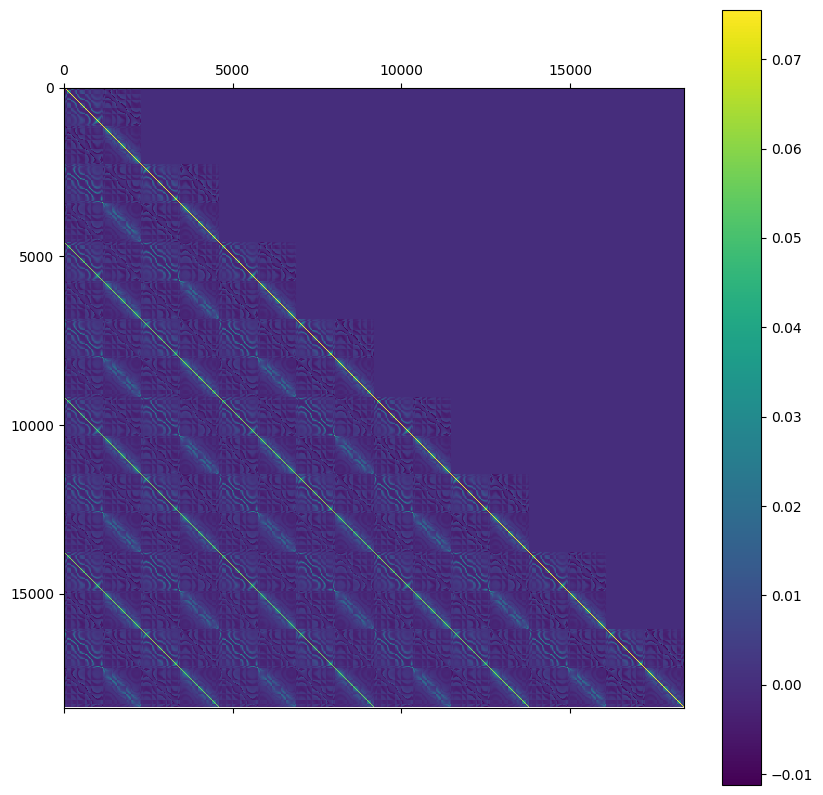

In [6]:
plt.figure(figsize=(10,10),dpi=100)

plt.matshow(Cmm_ana,fignum=1)
plt.colorbar()

In [7]:
np.diag(Cmm_ana)

array([0.07551208, 0.07551208, 0.07551208, ..., 0.07551208, 0.07551208,
       0.07551208])

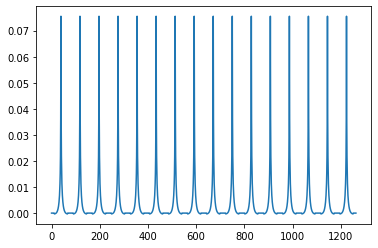

In [11]:
plt.plot(np.diag(CovMap_ana))

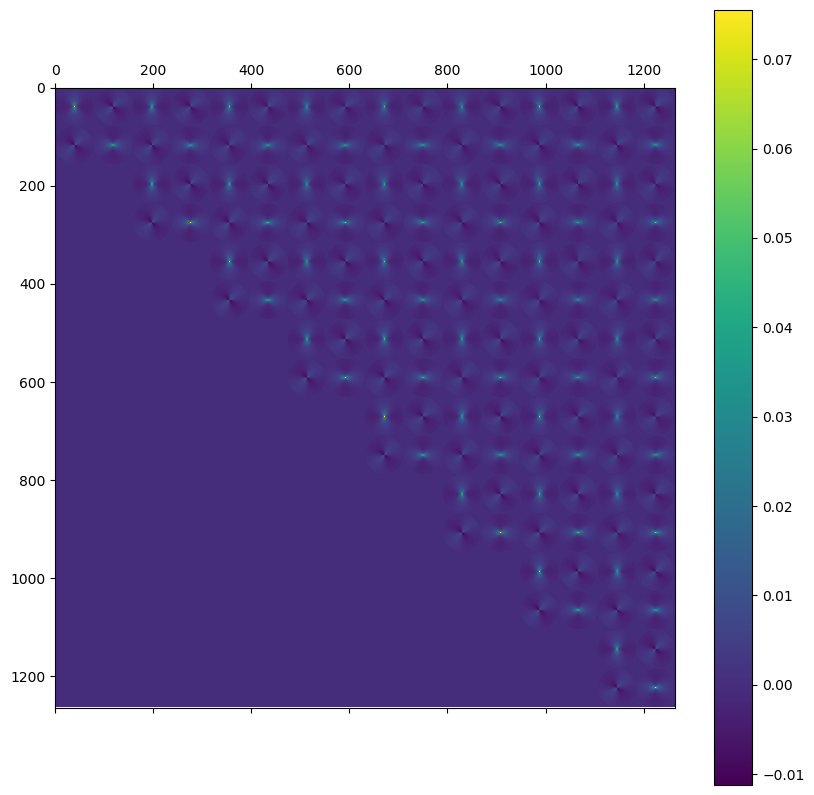

In [8]:
plt.figure(figsize=(10,10),dpi=100)
plt.matshow(CovMap_ana,fignum=1)
plt.colorbar()

In [9]:
CovMap_ana.shape

(1264, 1264)

In [88]:
class Optsovler:
    def __init__(self,nwfs,alt,X0):
        m = getAshape(nwfs) * X0.shape[0] * X0.shape[1] * 3 # xx xy yy
        m = int(m)
        n = alt.shape[0]
        n = int(n)
        self.A = np.zeros((m,n))
        self.b = np.zeros(m)
        self.x_k = np.random.rand(n)
        self.x_sol = np.zeros(n)
        self.wfsrow = X0.shape[0]*X0.shape[1]
def getAshape(nwfs):
    return int((nwfs+1)*nwfs/2)

In [127]:
def CovMap_from_Cn2 (CovMapMask,telDiam,zenith,shnxsub,r0,Cn2,l0,alt,nwfs,gspos,gsalt,timedelay=0,windspeed=[],winddir=[]):
    dtor   = np.pi/180
    astor  = dtor/60/60
    zenith = zenith*dtor
    gspos  = gspos*astor
    subAperSize = telDiam/shnxsub
    r0     = r0*math.cos(zenith)**0.6
    gsalt  = gsalt/math.cos(zenith)
    alt    = alt/math.cos(zenith)
    Cn2    = Cn2/np.sum(Cn2)
    l0     = np.where(l0>1000,1000,l0)
    windflag = 0 if timedelay==0 else 1
    if windflag :
        print("Temporal evolution enabled!")
        windspeed   = np.array(windspeed)
        winddir     = np.array(winddir)*dtor
        windspeed_x = windspeed*np.cos(winddir)
        windspeed_y = windspeed*np.sin(winddir)
    CovMap_ana = np.zeros(CovMapMask.shape)
    x0 = y0    = np.arange(-shnxsub+1,shnxsub,1)
    X0,Y0      = np.meshgrid(x0,y0)
    X0         = X0*subAperSize
    Y0         = Y0*subAperSize
    n_deltaY   = Y0.shape[0]
    k         = 1/subAperSize/subAperSize
    lambda2   = (0.5e-6/2/np.pi/astor)**2
    time_start = time.time()
    print("Begin calculating Cov Map from Cn2")
    optsolver = Optsovler(nwfs, alt, X0)
    print(Cn2)
    optsolver.x_sol = Cn2
    optcnt = 0
    # print(optsolver.A.shape)
    for wfs_1 in range(nwfs):
        for wfs_2 in range(wfs_1,nwfs):
            #print("begin calculating for WFS # "+str(wfs_1)+" and WFS #"+str(wfs_2)+" !")
            gsalt_1 = gsalt[wfs_1]
            gsalt_2 = gsalt[wfs_2]
            for li in range(alt.shape[0]):
                tmpoptcnt = optcnt
                # print(tmpoptcnt)
                layer_alt = alt[li]
                l0_i      = l0[li]
                Cn2h      = r0**(-5/3.)*Cn2[li]
                dx_li_wind= 0
                dy_li_wind= 0
                if windflag :
                    dx_li_wind = windspeed_x[li] * timedelay
                    dy_li_wind = windspeed_y[li] * timedelay
                #print("Processing altitude = "+str(layer_alt)+" m")
                if gsalt_1*gsalt_2 == 0:
                    if gsalt_1 == gsalt_2:
                        # 2 NGS
                        Xi = X0 - layer_alt*(gspos[wfs_2,0]-gspos[wfs_1,0]) - dx_li_wind
                        Yi = Y0 - layer_alt*(gspos[wfs_2,1]-gspos[wfs_1,1]) - dy_li_wind
                        # no need to scale subAperSize
                        subAperSize_i = subAperSize
                    else:
                        # 1 NGS 1 LGS
                        raise Exception('Cov Map between LGS and NGS is not valid!')
                else:
                    # 2 LGS
                    # Average gsalt is used here, which is not precise
                    if gsalt_1<layer_alt or gsalt_2<layer_alt:
                        raise Exception('Turbulence layer is higher than LGS altitude!')
                    else:
                        avg_gsalt = (gsalt_1+gsalt_2)/2
                        Xi = (1-layer_alt/avg_gsalt)*X0 - layer_alt*(gspos[wfs_2,0]-gspos[wfs_1,0]) - dx_li_wind
                        Yi = (1-layer_alt/avg_gsalt)*Y0 - layer_alt*(gspos[wfs_2,1]-gspos[wfs_1,1]) - dy_li_wind
                        subAperSize_i = (1-layer_alt/avg_gsalt)*subAperSize
            
                Cov_XX = (-2 * DPHI(Xi,Yi,l0_i) + DPHI(Xi+subAperSize_i,Yi,l0_i) + DPHI(Xi-subAperSize_i,Yi,l0_i))*0.5
                optxxA = Cov_XX * k * lambda2 * r0 **(-5/3.) # for opt genreate A, xx
                Cov_XX = Cov_XX *k*lambda2*np.abs(Cn2h)
                optAstart = tmpoptcnt*optsolver.wfsrow
                optAend = (tmpoptcnt+1)*optsolver.wfsrow
                # print(optAstart)
                optxxA = optxxA.flatten()
                optsolver.A[optAstart:optAend,li] = optxxA
                
                #optsolver.b[optAstart:optAend] = Cov_XX.flatten()
                tmpoptcnt += 1
                Cov_YY = (-2 * DPHI(Xi,Yi,l0_i) + DPHI(Xi,subAperSize_i+Yi,l0_i) + DPHI(Xi,-subAperSize_i+Yi,l0_i))*0.5
                optyyA = Cov_YY * k * lambda2 * r0 **(-5/3.) # for opt genreate A, yy
                Cov_YY = Cov_YY *k*lambda2*np.abs(Cn2h)
                optAstart = tmpoptcnt*optsolver.wfsrow
                # print(optAstart)
                optAend = (tmpoptcnt+1)*optsolver.wfsrow
                optyyA = optyyA.flatten()
                optsolver.A[optAstart:optAend,li] = optyyA
                #optsolver.b[optAstart:optAend] = Cov_YY.flatten()
                Cov_XY = -DPHI(Xi+np.sqrt(2)*subAperSize_i/2,Yi-np.sqrt(2)*subAperSize_i/2,l0_i) +\
                          DPHI(Xi+np.sqrt(2)*subAperSize_i/2,Yi+np.sqrt(2)*subAperSize_i/2,l0_i) +\
                          DPHI(Xi-np.sqrt(2)*subAperSize_i/2,Yi-np.sqrt(2)*subAperSize_i/2,l0_i) -\
                          DPHI(Xi-np.sqrt(2)*subAperSize_i/2,Yi+np.sqrt(2)*subAperSize_i/2,l0_i)
                Cov_XY = Cov_XY/4
                optxyA = Cov_YY * k * lambda2 * r0 **(-5/3.) # for opt genreate A, xy
                Cov_XY = Cov_XY *k*lambda2*np.abs(Cn2h)
                tmpoptcnt += 1
                optAstart = tmpoptcnt*optsolver.wfsrow
                # print(optAstart)
                optAend = (tmpoptcnt+1)*optsolver.wfsrow
                optxyA = optxyA.flatten() 
                optsolver.A[optAstart:optAend,li] = optxyA
                #optsolver.b[optAstart:optAend] = Cov_XY.flatten()

                CovMap_ana[n_deltaY*2*wfs_1:n_deltaY*2*wfs_1+n_deltaY,n_deltaY*2*wfs_2:n_deltaY*2*wfs_2+n_deltaY] += Cov_XX
                CovMap_ana[n_deltaY*2*wfs_1+n_deltaY:n_deltaY*2*(wfs_1+1),n_deltaY*2*wfs_2+n_deltaY:n_deltaY*2*(wfs_2+1)] += Cov_YY
                CovMap_ana[n_deltaY*2*wfs_1:n_deltaY*2*wfs_1+n_deltaY,n_deltaY*2*wfs_2+n_deltaY:n_deltaY*2*(wfs_2+1)] += Cov_XY
                CovMap_ana[n_deltaY*2*wfs_1+n_deltaY:n_deltaY*2*(wfs_1+1),n_deltaY*2*wfs_2:n_deltaY*2*wfs_2+n_deltaY] += Cov_XY
            
            
            tmpoptcnt = optcnt
            optAstart = tmpoptcnt*optsolver.wfsrow
            optAend = (tmpoptcnt+1)*optsolver.wfsrow
            optsolver.b[optAstart:optAend] = CovMap_ana[n_deltaY*2*wfs_1:n_deltaY*2*wfs_1+n_deltaY,n_deltaY*2*wfs_2:n_deltaY*2*wfs_2+n_deltaY].flatten()
            tmpoptcnt += 1 
            optAstart = tmpoptcnt*optsolver.wfsrow
            optAend = (tmpoptcnt+1)*optsolver.wfsrow
            optsolver.b[optAstart:optAend] = CovMap_ana[n_deltaY*2*wfs_1+n_deltaY:n_deltaY*2*(wfs_1+1),n_deltaY*2*wfs_2+n_deltaY:n_deltaY*2*(wfs_2+1)].flatten()
            tmpoptcnt += 1
            optAstart = tmpoptcnt*optsolver.wfsrow
            optAend = (tmpoptcnt+1)*optsolver.wfsrow
            optsolver.b[optAstart:optAend] = CovMap_ana[n_deltaY*2*wfs_1+n_deltaY:n_deltaY*2*(wfs_1+1),n_deltaY*2*wfs_2:n_deltaY*2*wfs_2+n_deltaY].flatten()
            optcnt += 3
            
    time_end = time.time()
    print("Cov Map generation finished! Time taken = %.1f seconds."%(time_end-time_start))
    hdu = fits.PrimaryHDU(CovMap_ana)
    hdu.writeto("CovMap_ana_full.fits",overwrite=1)
    CovMap_ana = CovMap_ana * CovMapMask
    return CovMap_ana.astype('float64'), optsolver

In [128]:
CovMap_ana, optsolver = CovMap_from_Cn2(CovMapMask,telDiam,zenith,shnxsub,r0,Cn2,l0,alt,nwfs,gspos,gsalt)

Begin calculating Cov Map from Cn2
[0.59000003 0.02       0.04       0.06       0.01       0.05
 0.09000001 0.04       0.05       0.05      ]
Cov Map generation finished! Time taken = 3.4 seconds.


In [129]:
np.allclose(optsolver.A @ optsolver.x_sol,optsolver.b)

False

In [133]:
np.allclose(optsolver.A[0:100] @ optsolver.x_sol,optsolver.b[0:100])

True

In [135]:
optsolver.A[0]@optsolver.x_sol

-0.00028978806319383105

In [12]:
optsolver.b[0] 

NameError: name 'optsolver' is not defined

In [13]:
Cmm_ana.shape

(18368, 18368)

In [15]:
18368 * 18368 * 10 * 8 / 1024 / 1024 / 1024.

25.13702392578125